#AI PPT Builder

In [1]:
!pip install -q langchain langchain-google-genai langchain_core langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 290.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.3/990.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.2/374.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 6.5 MB/s eta 0:00:00


In [2]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [16]:
from pydantic import BaseModel, Field
from typing import List

class SlideSchema(BaseModel):
    title: str = Field(..., title="Title", description="The title of the Slide.")
    content: str = Field(..., title="Content", description="The content of the slide.")

    model_config = {
        "json_schema_extra": {
            "examples": """
                "title": "Introduction",
                "content": "This slide introduces the main topics of the presentation.",
                """
        }
    }


class PPTFileSchema(BaseModel):
    title: str = Field(..., title="Title", description="The title of the PowerPoint presentation.")
    description: str = Field(..., title="Description", description="A brief description of the PowerPoint presentation.")
    slides: List[SlideSchema] = Field(..., title="Slides", description="A list of slides in the PowerPoint presentation.")

    model_config = {
      "json_schema_extra": {
          "examples": """
              "title": "Project Presentation",
              "description": "A detailed presentation of the project including objectives, methodology, and results.",
              "slides": [
                  {
                      "title": "Introduction",
                      "content": "This slide introduces the main topics of the presentation."
                  },
                  {
                      "title": "Methodology",
                      "content": "This slide explains the methodology used in the project."
                  },
                  {
                      "title": "Results",
                      "content": "This slide presents the results of the project."
                  }
              ] """
          }
      }

In [4]:
prompt_template = """
You are a professional PowerPoint creator with expertise in designing compelling and informative presentations. Your task is to create a PowerPoint presentation on the following criteria:

Topic:
{topic}

Objective:
{objective}

Target Audience:
{target_audience}

Number of Slides:
{n_slides}

Slide Breakdown:
{slide_breakdown}

You must answer in the following language: {lang}

You must respond as a JSON object:
{format_instructions}
"""

In [17]:
from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser(pydantic_object=PPTFileSchema)

In [18]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
  template=prompt_template,
  input_variables=[
    "topic",
    "objective",
    "target_audience",
    "n_slides",
    "slide_breakdown",
    "lang"
  ],
  partial_variables={"format_instructions": parser.get_format_instructions()}
)

In [19]:
from langchain_google_genai import GoogleGenerativeAI

model = GoogleGenerativeAI(model="gemini-1.5-pro")

In [20]:
chain = prompt | model | parser

In [22]:
from pydantic import BaseModel, Field, validator

class SlideSchema(BaseModel):
    topic: str = Field(..., min_length=1, max_length=100, description="The topic of the slide presentation")
    objective: str = Field(..., min_length=1, max_length=200, description="The objective of the slide presentation")
    target_audience: str = Field(..., min_length=1, max_length=100, description="The target audience of the slide presentation")
    n_slides: int = Field(..., ge=1, le=100, description="The number of slides in the presentation")
    slide_breakdown: str = Field(..., description="A breakdown of the content for each slide")
    lang: str = Field(..., min_length=2, max_length=2, pattern='^[a-zA-Z]{2}$', description="Language code for the presentation")

    @validator('lang')
    def validate_language(cls, v):
        if v.lower() not in ['en', 'es', 'fr', 'de', 'it', 'pt']:  # Add more language codes as necessary
            raise ValueError('Invalid language code')
        return v

    @validator('slide_breakdown')
    def validate_slide_breakdown(cls, v):
        if not v:
            raise ValueError('Slide breakdown cannot be empty')
        return v

class SlidePresentation:
    def __init__(self, slide_schema: SlideSchema):
        self._slide_schema = slide_schema

    @property
    def topic(self) -> str:
        return self._slide_schema.topic

    @topic.setter
    def topic(self, value: str):
        self._slide_schema.topic = value

    @property
    def objective(self) -> str:
        return self._slide_schema.objective

    @objective.setter
    def objective(self, value: str):
        self._slide_schema.objective = value

    @property
    def target_audience(self) -> str:
        return self._slide_schema.target_audience

    @target_audience.setter
    def target_audience(self, value: str):
        self._slide_schema.target_audience = value

    @property
    def n_slides(self) -> int:
        return self._slide_schema.n_slides

    @n_slides.setter
    def n_slides(self, value: int):
        self._slide_schema.n_slides = value

    @property
    def slide_breakdown(self) -> str:
        return self._slide_schema.slide_breakdown

    @slide_breakdown.setter
    def slide_breakdown(self, value: str):
        self._slide_schema.slide_breakdown = value

    @property
    def lang(self) -> str:
        return self._slide_schema.lang

    @lang.setter
    def lang(self, value: str):
        self._slide_schema.lang = value

    def validate_and_return(self) -> dict:
        # Validate the SlideSchema and return the values as a dictionary
        return self._slide_schema.dict()

<ipython-input-22-efa384b201fd>:11: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  @validator('lang')
<ipython-input-22-efa384b201fd>:17: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  @validator('slide_breakdown')


In [23]:
schema = SlideSchema(
    topic="Introduction to Python",
    objective="Teach the basics of Python programming",
    target_audience="Beginners",
    n_slides=10,
    slide_breakdown="1. Introduction\n2. Variables\n3. Data Types\n4. Control Flow\n5. Functions\n6. Modules\n7. File I/O\n8. Error Handling\n9. Classes\n10. Conclusion",
    lang="es"
)

In [24]:
presentation = SlidePresentation(slide_schema=schema)
print(presentation.validate_and_return())

{'topic': 'Introduction to Python', 'objective': 'Teach the basics of Python programming', 'target_audience': 'Beginners', 'n_slides': 10, 'slide_breakdown': '1. Introduction\n2. Variables\n3. Data Types\n4. Control Flow\n5. Functions\n6. Modules\n7. File I/O\n8. Error Handling\n9. Classes\n10. Conclusion', 'lang': 'es'}


In [25]:
result = chain.invoke(presentation.validate_and_return())

In [26]:
result

{'title': 'Introducción a Python',
 'description': 'Una presentación introductoria a los conceptos básicos de programación en Python, diseñada para principiantes.',
 'slides': [{'title': 'Bienvenido a Python!',
   'content': 'En esta presentación, vamos a explorar el mundo de la programación con Python. Aprenderemos los fundamentos para empezar a escribir tus propios programas.'},
  {'title': 'Variables',
   'content': "Las variables son como contenedores que almacenan información. En Python, se definen usando un nombre y se les asigna un valor. \n Ejemplo: \n `nombre = 'Juan'\n edad = 25`"},
  {'title': 'Tipos de Datos',
   'content': "Python maneja diferentes tipos de datos como: \n - Números (enteros, decimales) \n - Cadenas de texto \n - Booleanos (Verdadero/Falso) \n Ejemplo: \n `edad = 25 # Número entero\n nombre = 'Juan' # Cadena de texto\n activo = True # Booleano`"},
  {'title': 'Control de Flujo',
   'content': 'Controla el orden en que se ejecutan las instrucciones en tu pro

In [27]:
!pip install -q python-pptx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 11.8 MB/s eta 0:00:00


In [67]:
from pptx import Presentation
from pptx.util import Inches

# Load the template presentation
template_path = '/content/template1.pptx'

def create_pptx_file(template_path, result, images):
    prs = Presentation(template_path)

    # Remove all existing slides
    for i in range(len(prs.slides) - 1, -1, -1):
        rId = prs.slides._sldIdLst[i].rId
        prs.part.drop_rel(rId)
        del prs.slides._sldIdLst[i]

    file_title = result['title'].replace(" ", "_")

    # Add a title slide
    slide_layout = prs.slide_layouts[0]  # Assuming the first layout is the title slide layout
    slide = prs.slides.add_slide(slide_layout)
    title = slide.shapes.title
    subtitle = slide.placeholders[1]
    title.text = result['title']
    subtitle.text = result['description']

    # Add content slides
    for slide_index, slide_content in enumerate(result['slides']):
        slide_layout = prs.slide_layouts[1]  # Assuming the second layout is a content slide layout
        slide = prs.slides.add_slide(slide_layout)
        title = slide.shapes.title
        content_shape = slide.placeholders[1]

        title.text = slide_content['title']
        content_shape.text = slide_content['content']

        # Add images to the slide if any
        if slide_index < len(images):
            for image in images[slide_index]:
                left = Inches(image['left'])
                top = Inches(image['top'])
                width = Inches(image['width'])
                height = Inches(image['height'])
                slide.shapes.add_picture(image['path'], left, top, width=width, height=height)

    # Save the presentation
    pptx_file = f"/content/{file_title}.pptx"
    prs.save(pptx_file)
    return "Done!"

In [66]:
images = [
    [
        {
            'path': '/content/Python-Symbol.png',
            'left': 5,
            'top': 4,
            'width': 2.5,
            'height': 2
        }
    ],
    [
        {
            'path': '/content/code.jpg',
            'left': 5,
            'top': 4,
            'width': 2.5,
            'height': 2
        },
    ]
]

In [58]:
create_pptx_file(template_path, result, images)

'/content/Introducción_a_Python.pptx'

In [73]:
import json

def full_workflow(topic, objective, target_audience, n_slides, slide_breakdown, lang):
  schema = SlideSchema(
      topic=topic,
      objective=objective,
      target_audience=target_audience,
      n_slides=n_slides,
      slide_breakdown=slide_breakdown,
      lang=lang
  )

  presentation = SlidePresentation(slide_schema=schema)
  result = chain.invoke(presentation.validate_and_return())

  create_pptx_file(template_path, result, images)
  return json.dumps(result, indent=4)

In [59]:
!pip install -q gradio

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━

In [74]:
import gradio as gr

demo = gr.Interface(fn=full_workflow,
                    inputs=[gr.Textbox(label="Topic: "),
                            gr.TextArea(label="Objective: "),
                            gr.Textbox(label="Target Audience: "),
                            gr.Number(label="Number of slides: "),
                            gr.TextArea(label="Slide breakdown: "),
                            gr.Dropdown(["en", "es", "fr", "de", "it", "pt"], label="Language: ")
                            ], outputs=gr.TextArea(label="Result: "))

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://545dd85c4515eb1fe8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# **VERSION 1.0**:

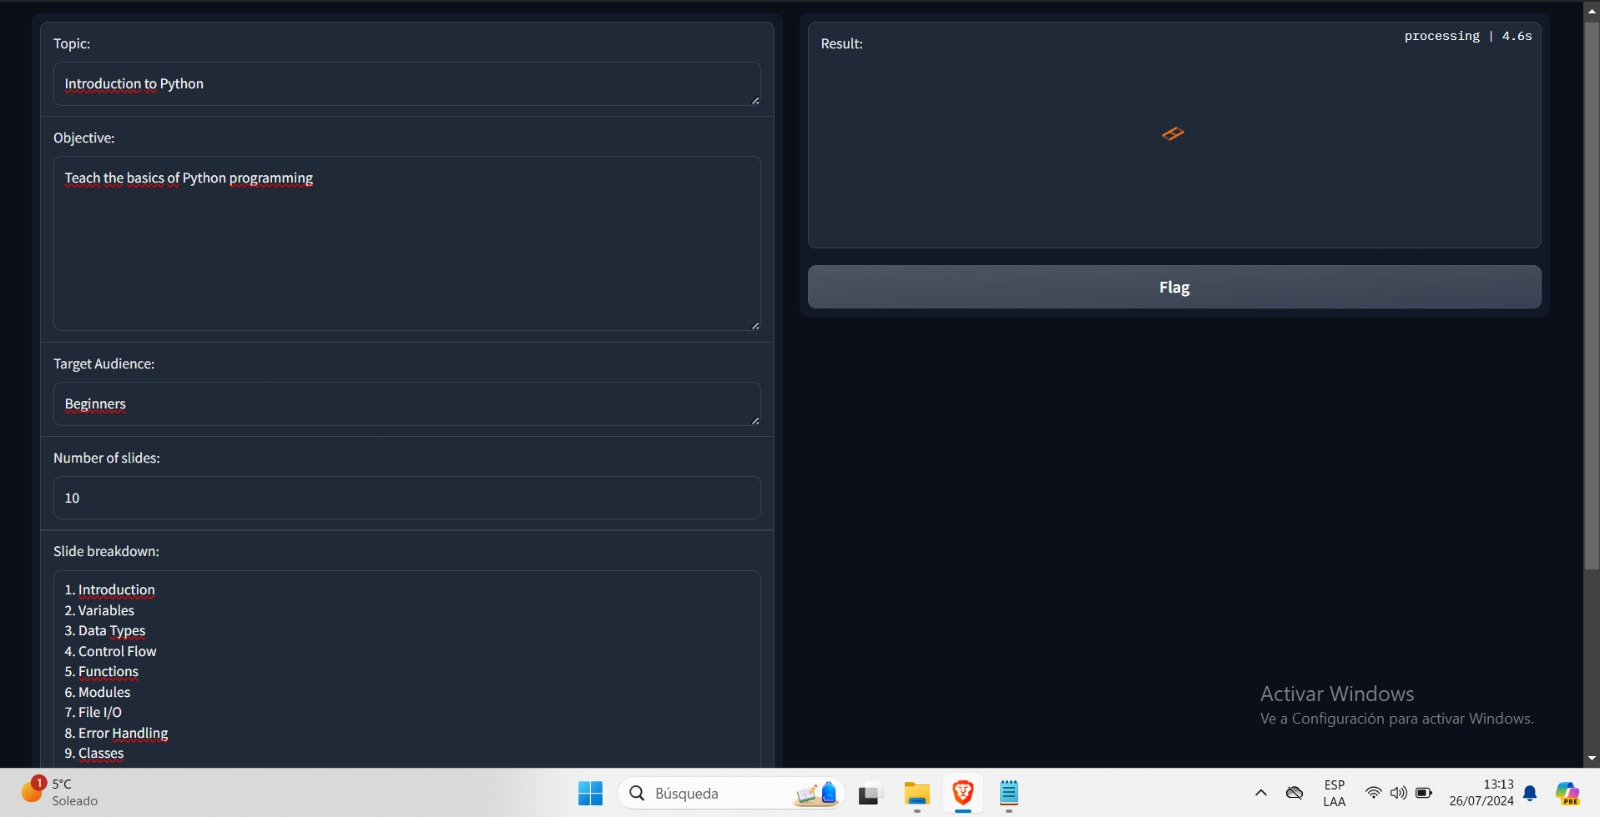

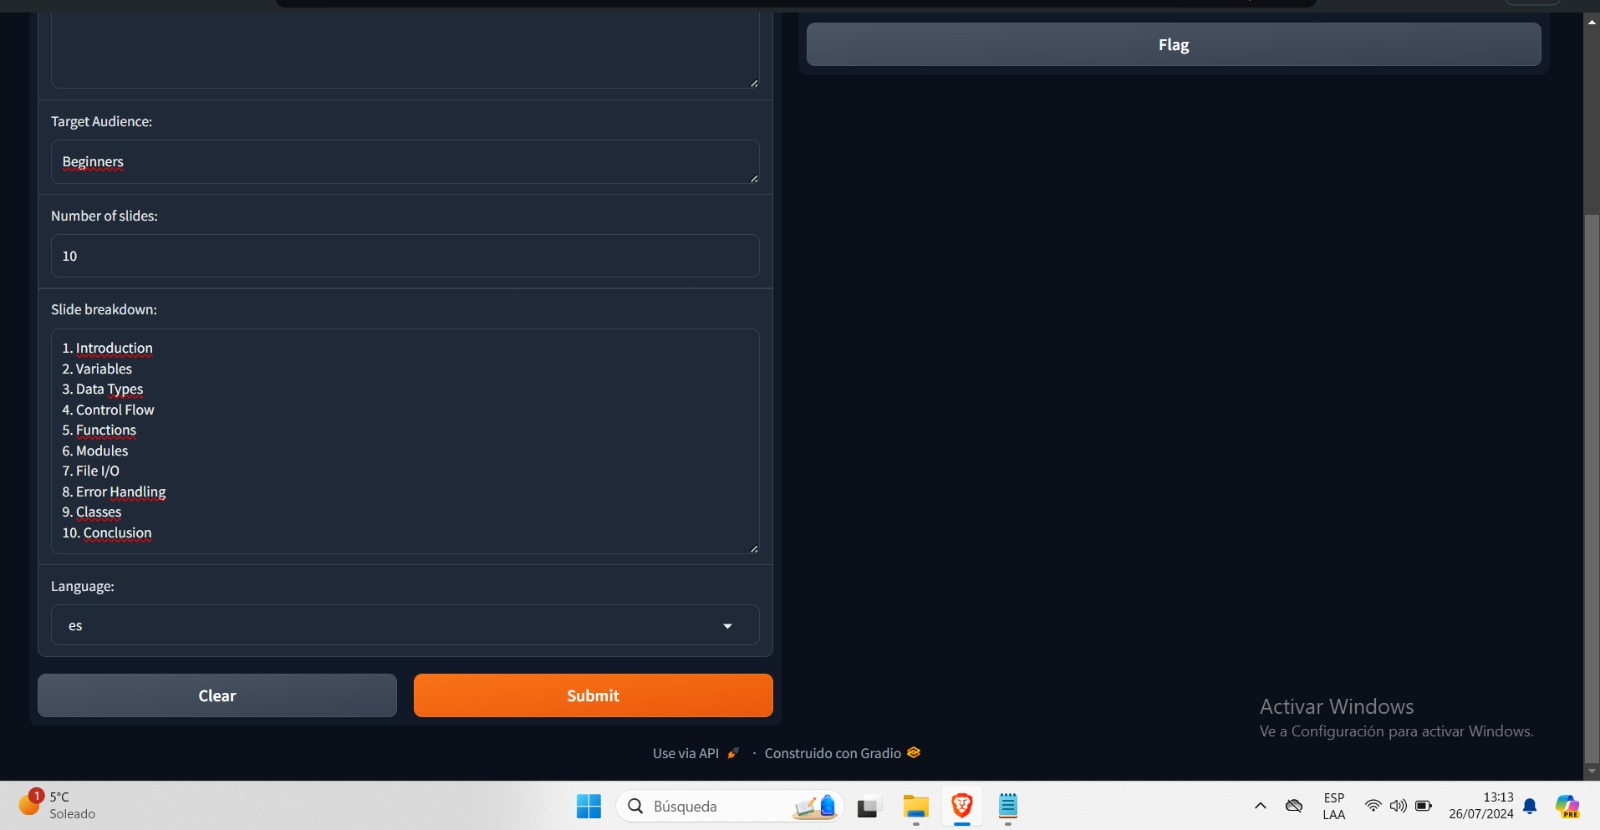

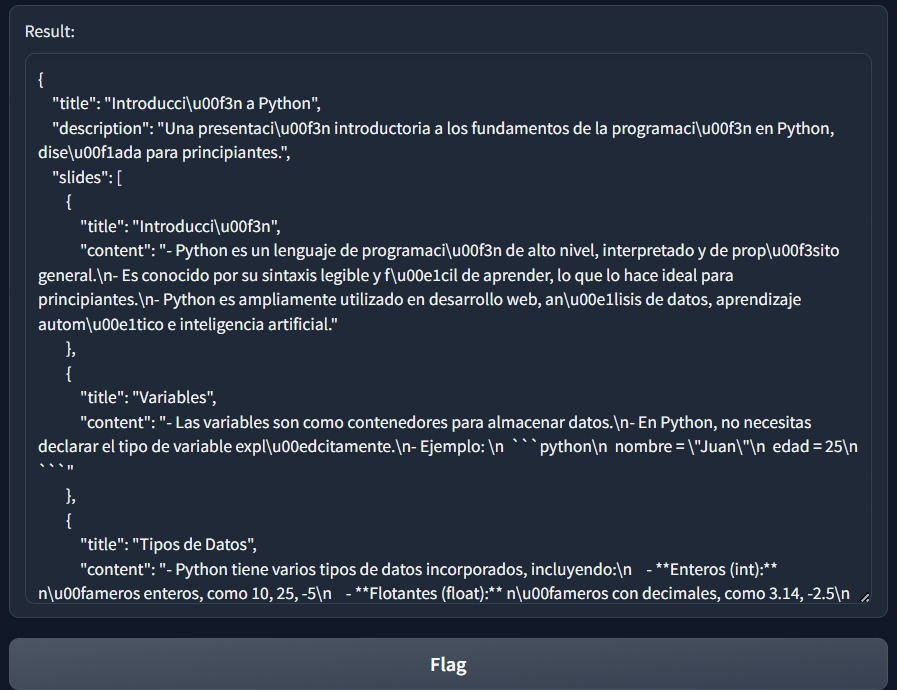

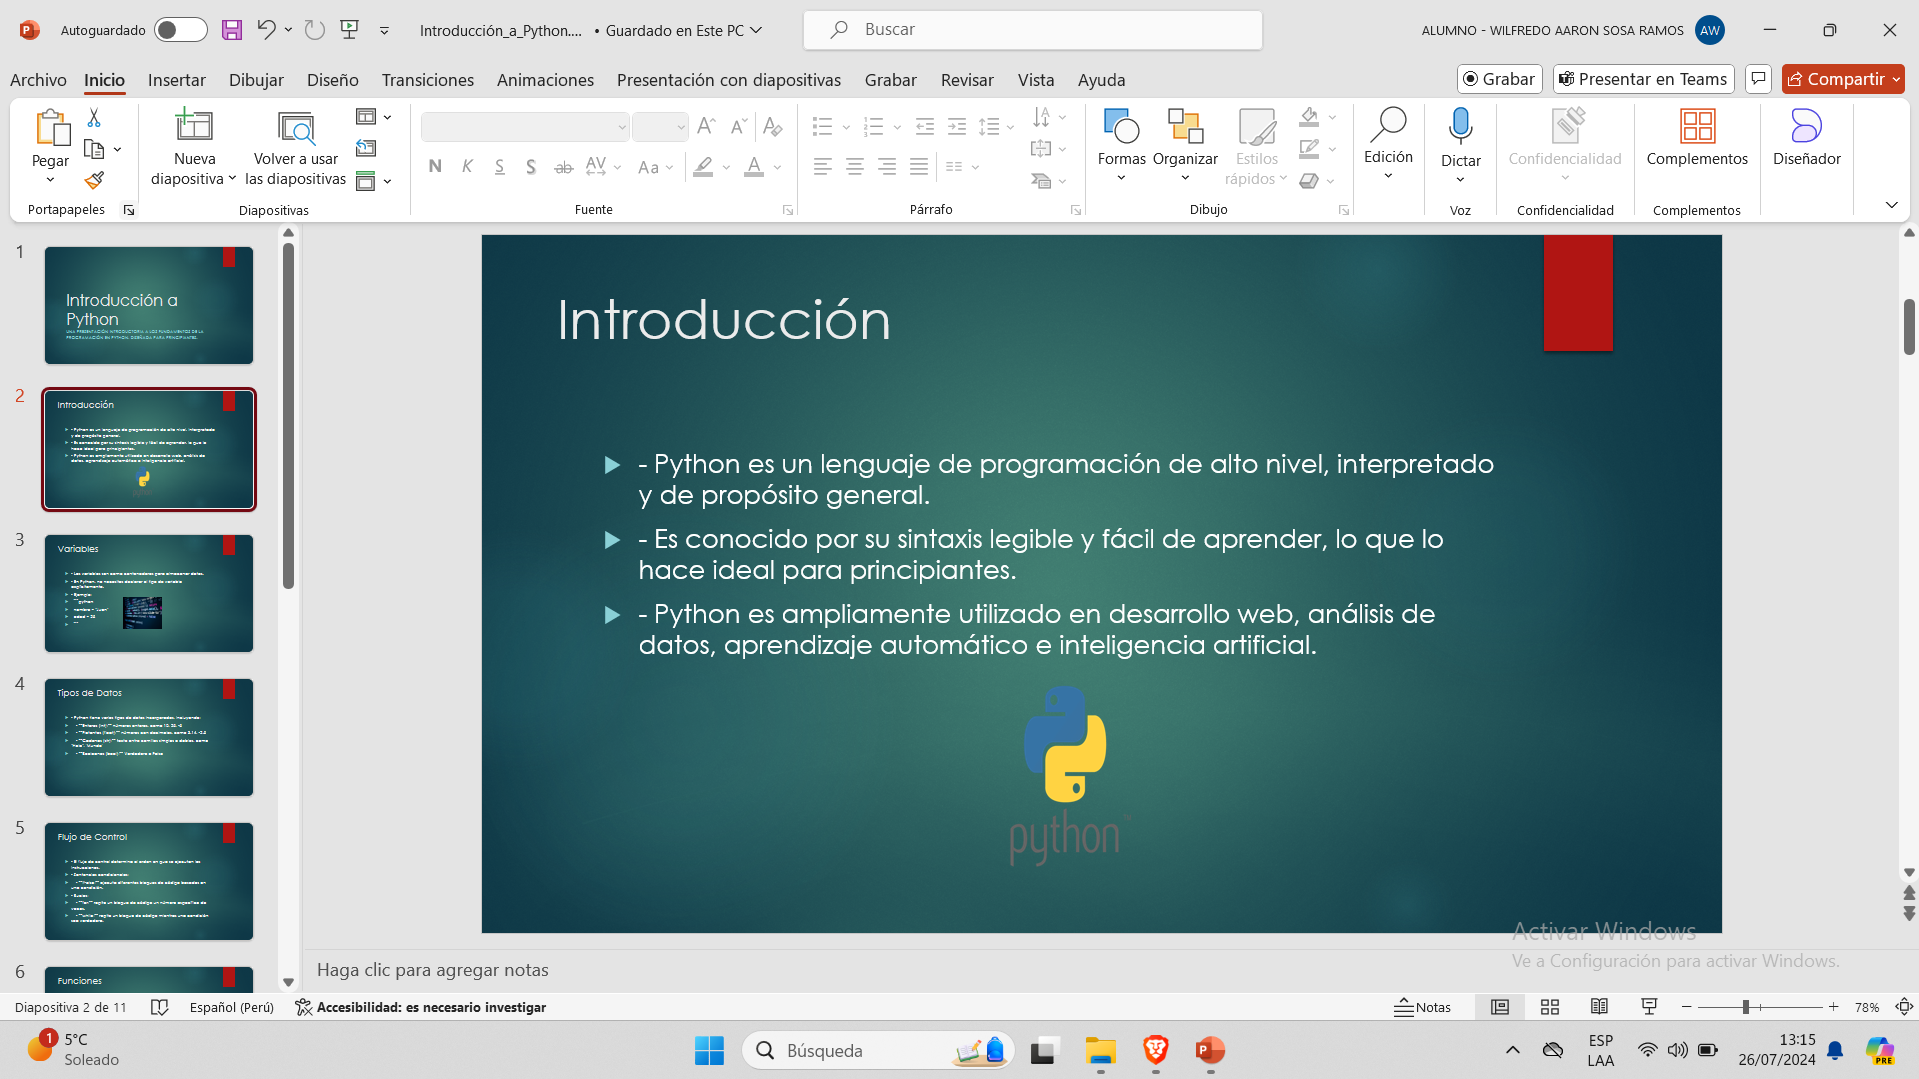